In [1]:
import datetime
import io
import json
import time
import pandas as pd
import requests
from bs4 import BeautifulSoup

def getDailyConfirmed():
    # URL of the data file (time_series_covid19_confirmed_global.csv) from CSSE at Johns Hopkins University GitHub
    url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/" \
          "csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"

    # Fetch data from the GitHub
    global_confirmed_data = requests.get(url).content

    # Read the file and turn it in the dataframe type and set the first row as the column name
    df = pd.read_csv(io.StringIO(global_confirmed_data.decode('utf-8')), header=0, names=None)

    # Get the Hong Kong time series data according to the Province/State value and
    # Get all the columns except the first 4 columns and
    # Rename its row name as confirmed
    totalConfirmed_data = ((df.loc[df['Province/State'] == 'Hong Kong']).iloc[:, 4:]).rename(index={71: 'confirmed'})

    # Calculate the daily confirmed cases
    dailyConfirmed_data = totalConfirmed_data.copy(deep=True)
    for i in range(len(dailyConfirmed_data.columns) - 1, 0, -1):
        dailyConfirmed_data.iloc[0, i] -= dailyConfirmed_data.iloc[0, i - 1]

    # Print the total confirmed cases on each day and daily confirmed cases
    print(totalConfirmed_data)
    print(dailyConfirmed_data)
    return dailyConfirmed_data


def getVaccinations():
    # URL of the data file (vaccinations-by-age-group.csv) from Our World in Data on GitHub
    url = "https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/" \
          "vaccinations/vaccinations-by-age-group.csv"

    # Fetch data from the GitHub
    vaccinations_data = requests.get(url).content

    # Read the file and turn it in the dataframe type and set the first row as the column name
    df = pd.read_csv(io.StringIO(vaccinations_data.decode('utf-8')), header=0, names=None)

    # Get the data about Hong Kong and get the transpose of the dataset
    vaccinations_data = ((df.loc[df['location'] == 'Hong Kong']).iloc[:, 1:6]).T.iloc[:, 5:]

    # Reset the columns' names
    vaccinations_data.columns = list(vaccinations_data.iloc[0])

    # Drop the original column name "date"
    vaccinations_data = vaccinations_data.drop("date", axis=0)

    # Get the first day of vaccination which has 8 columns (8 age groups)
    each_day = vaccinations_data.iloc[:, :8]

    # Get and set the date to the same format as the confirmed cases
    date = list(map(int, each_day.columns[0].split("-")))
    date = "/".join(list(map(str, [date[1] % 100, date[2] % 100, date[0] % 100])))

    # Reset the rows' name
    each_day.columns = list(each_day.iloc[0])

    # Drop the age_group row and reset the index as default value
    each_day = each_day.drop("age_group", axis=0).reset_index()

    # Conduct the dataframe from 3*8 to 24*2
    each_day = each_day.set_index(['index']).stack().reset_index()
    each_day.columns = ['type', 'age', date]

    # Merge the type and age group together
    each_day.insert(0, "type_age", each_day['type'] + "_" + each_day['age'])

    # Drop the two rows and initialize the dataframe named "vaccinations_set" to store the processed vaccinations data
    vaccinations_set = each_day.drop(["type", "age"], axis=1)

    # As same as the previous steps and process all the data
    for i in range(16, vaccinations_data.shape[1], 8):
        each_day = vaccinations_data.iloc[:, (i - 8):i]
        date = list(map(int, each_day.columns[0].split("-")))
        date = "/".join(list(map(str, [date[1] % 100, date[2] % 100, date[0] % 100])))
        each_day.columns = list(each_day.iloc[0])
        each_day = each_day.drop("age_group", axis=0).reset_index()
        each_day = each_day.set_index(['index']).stack().reset_index()
        each_day.columns = ['type', 'age', date]
        vaccinations_set.insert(vaccinations_set.shape[1], date, each_day[date])

    # Print the processed data, the format of data is [row index: different age groups and types][column names: date]
    print(vaccinations_set)
    return vaccinations_set


def getLeavingArrivals():
    # Create a dataframe
    leavingArrivals_data = pd.DataFrame({"1/23/20": {"residentsArrival": 0, "mainlandArrival": 0, "otherArrival": 0,
                                                     "totalArrival": 0, "residentsDeparture": 0, "mainlandDeparture": 0,
                                                     "otherDeparture": 0, "totalDeparture": 0}})
    # Set the beginning and end time date
    begin = datetime.date(2020, 1, 24)
    today = time.localtime()
    end = datetime.date(today.tm_year, today.tm_mon, today.tm_mday)

    # Get all the data from government website
    for i in range((end - begin).days):
        # Set the date time
        date = begin + datetime.timedelta(days=i)

        # Get the web info from government web with request
        source = requests.get("https://www.immd.gov.hk/hkt/stat_" + str(date).replace("-", "") + ".html")

        # Print the current web address, show the process
        print("https://www.immd.gov.hk/hkt/stat_" + str(date).replace("-", "") + ".html")

        # Decoding the info so that the chinese shows normally
        source.encoding = source.apparent_encoding

        # Create a parser with BeautifulSoup
        parser = BeautifulSoup(source.text, 'html.parser')

        # Find all the "<tr>" stored the needed data with class name "p tr-boldText"
        parser_tr = parser.findAll(name="tr", attrs={"class": "p tr-boldText"})

        # Some of them named "q tr-boldText"
        if len(parser_tr) == 0:
            parser_tr = parser.findAll(name="tr", attrs={"class": "q tr-boldText"})

        # Find the needed data one by one with parser get_value() method and also delete the "," inside the number
        residentsArrival = parser_tr[0].find(name='td', attrs={
            "headers": "Hong_Kong_Residents_Arrival"}).get_text().replace(",", "")
        mainlandArrival = parser_tr[0].find(name='td', attrs={
            "headers": "Mainland_Visitors_Arrival"}).get_text().replace(",", "")
        otherArrival = parser_tr[0].find(name='td', attrs={
            "headers": "Other_Visitors_Arrival"}).get_text().replace(",", "")
        totalArrival = parser_tr[0].find(name='td', attrs={
            "headers": "Total_Arrival"}).get_text().replace(",", "")
        residentsDeparture = parser_tr[0].find(name='td', attrs={
            "headers": "Hong_Kong_Residents_Departure"}).get_text().replace(",", "")
        mainlandDeparture = parser_tr[0].find(name='td', attrs={
            "headers": "Mainland_Visitors_Departure"}).get_text().replace(",", "")
        otherDeparture = parser_tr[0].find(name='td', attrs={
            "headers": "Other_Visitors_Departure"}).get_text().replace(",", "")
        totalDeparture = parser_tr[0].find(name='td', attrs={
            "headers": "Total_Departure"}).get_text().replace(",", "")

        # Store them into the dataframe with the same column name as dailyConfirmed_data
        # and convert the type of data to int
        leavingArrivals_data.insert(leavingArrivals_data.shape[1],
                                    str(date.month) + "/" + str(date.day) + "/" + str(date.year),
                                    [int(residentsArrival), int(mainlandArrival), int(otherArrival), int(totalArrival),
                                     int(residentsDeparture),
                                     int(mainlandDeparture), int(otherDeparture), int(totalDeparture)])

    # Delete the first column which is meaningless
    leavingArrivals_data = leavingArrivals_data.drop(columns="1/23/20")

    # Write the data into the csv file, so that we can use the data in another way
    leavingArrivals_data.to_csv("leavingArrivals_data.csv")

    # Print the leaving and arrivals on each day
    print(leavingArrivals_data)
    return leavingArrivals_data


In [14]:


Vaccinations = getVaccinations()

LeavingArrivals = getLeavingArrivals()

           1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  1/28/20  \
confirmed        0        2        2        5        8        8        8   

           1/29/20  1/30/20  1/31/20  ...  10/17/22  10/18/22  10/19/22  \
confirmed       10       10       12  ...   1843209   1848163   1853287   

           10/20/22  10/21/22  10/22/22  10/23/22  10/24/22  10/25/22  \
confirmed   1858720   1864113   1870066   1875601   1881007   1886228   

           10/26/22  
confirmed   1891631  

[1 rows x 1009 columns]
           1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  1/28/20  \
confirmed        0        2        0        3        3        0        0   

           1/29/20  1/30/20  1/31/20  ...  10/17/22  10/18/22  10/19/22  \
confirmed        2        0        2  ...      5361      4954      5124   

           10/20/22  10/21/22  10/22/22  10/23/22  10/24/22  10/25/22  \
confirmed      5433      5393      5953      5535      5406      5221   

           10/26/22  
confirm

https://www.immd.gov.hk/hkt/stat_20200228.html
https://www.immd.gov.hk/hkt/stat_20200229.html
https://www.immd.gov.hk/hkt/stat_20200301.html
https://www.immd.gov.hk/hkt/stat_20200302.html
https://www.immd.gov.hk/hkt/stat_20200303.html
https://www.immd.gov.hk/hkt/stat_20200304.html
https://www.immd.gov.hk/hkt/stat_20200305.html
https://www.immd.gov.hk/hkt/stat_20200306.html
https://www.immd.gov.hk/hkt/stat_20200307.html
https://www.immd.gov.hk/hkt/stat_20200308.html
https://www.immd.gov.hk/hkt/stat_20200309.html
https://www.immd.gov.hk/hkt/stat_20200310.html
https://www.immd.gov.hk/hkt/stat_20200311.html
https://www.immd.gov.hk/hkt/stat_20200312.html
https://www.immd.gov.hk/hkt/stat_20200313.html
https://www.immd.gov.hk/hkt/stat_20200314.html
https://www.immd.gov.hk/hkt/stat_20200315.html
https://www.immd.gov.hk/hkt/stat_20200316.html
https://www.immd.gov.hk/hkt/stat_20200317.html
https://www.immd.gov.hk/hkt/stat_20200318.html
https://www.immd.gov.hk/hkt/stat_20200319.html
https://www.i

https://www.immd.gov.hk/hkt/stat_20200822.html
https://www.immd.gov.hk/hkt/stat_20200823.html
https://www.immd.gov.hk/hkt/stat_20200824.html
https://www.immd.gov.hk/hkt/stat_20200825.html
https://www.immd.gov.hk/hkt/stat_20200826.html
https://www.immd.gov.hk/hkt/stat_20200827.html
https://www.immd.gov.hk/hkt/stat_20200828.html
https://www.immd.gov.hk/hkt/stat_20200829.html
https://www.immd.gov.hk/hkt/stat_20200830.html
https://www.immd.gov.hk/hkt/stat_20200831.html
https://www.immd.gov.hk/hkt/stat_20200901.html
https://www.immd.gov.hk/hkt/stat_20200902.html
https://www.immd.gov.hk/hkt/stat_20200903.html
https://www.immd.gov.hk/hkt/stat_20200904.html
https://www.immd.gov.hk/hkt/stat_20200905.html
https://www.immd.gov.hk/hkt/stat_20200906.html
https://www.immd.gov.hk/hkt/stat_20200907.html
https://www.immd.gov.hk/hkt/stat_20200908.html
https://www.immd.gov.hk/hkt/stat_20200909.html
https://www.immd.gov.hk/hkt/stat_20200910.html
https://www.immd.gov.hk/hkt/stat_20200911.html
https://www.i

https://www.immd.gov.hk/hkt/stat_20210213.html
https://www.immd.gov.hk/hkt/stat_20210214.html
https://www.immd.gov.hk/hkt/stat_20210215.html
https://www.immd.gov.hk/hkt/stat_20210216.html
https://www.immd.gov.hk/hkt/stat_20210217.html
https://www.immd.gov.hk/hkt/stat_20210218.html
https://www.immd.gov.hk/hkt/stat_20210219.html
https://www.immd.gov.hk/hkt/stat_20210220.html
https://www.immd.gov.hk/hkt/stat_20210221.html
https://www.immd.gov.hk/hkt/stat_20210222.html
https://www.immd.gov.hk/hkt/stat_20210223.html
https://www.immd.gov.hk/hkt/stat_20210224.html
https://www.immd.gov.hk/hkt/stat_20210225.html
https://www.immd.gov.hk/hkt/stat_20210226.html
https://www.immd.gov.hk/hkt/stat_20210227.html
https://www.immd.gov.hk/hkt/stat_20210228.html
https://www.immd.gov.hk/hkt/stat_20210301.html
https://www.immd.gov.hk/hkt/stat_20210302.html
https://www.immd.gov.hk/hkt/stat_20210303.html
https://www.immd.gov.hk/hkt/stat_20210304.html
https://www.immd.gov.hk/hkt/stat_20210305.html
https://www.i

https://www.immd.gov.hk/hkt/stat_20210807.html
https://www.immd.gov.hk/hkt/stat_20210808.html
https://www.immd.gov.hk/hkt/stat_20210809.html
https://www.immd.gov.hk/hkt/stat_20210810.html
https://www.immd.gov.hk/hkt/stat_20210811.html
https://www.immd.gov.hk/hkt/stat_20210812.html
https://www.immd.gov.hk/hkt/stat_20210813.html
https://www.immd.gov.hk/hkt/stat_20210814.html
https://www.immd.gov.hk/hkt/stat_20210815.html
https://www.immd.gov.hk/hkt/stat_20210816.html
https://www.immd.gov.hk/hkt/stat_20210817.html
https://www.immd.gov.hk/hkt/stat_20210818.html
https://www.immd.gov.hk/hkt/stat_20210819.html
https://www.immd.gov.hk/hkt/stat_20210820.html
https://www.immd.gov.hk/hkt/stat_20210821.html
https://www.immd.gov.hk/hkt/stat_20210822.html
https://www.immd.gov.hk/hkt/stat_20210823.html
https://www.immd.gov.hk/hkt/stat_20210824.html
https://www.immd.gov.hk/hkt/stat_20210825.html
https://www.immd.gov.hk/hkt/stat_20210826.html
https://www.immd.gov.hk/hkt/stat_20210827.html
https://www.i

https://www.immd.gov.hk/hkt/stat_20220129.html
https://www.immd.gov.hk/hkt/stat_20220130.html
https://www.immd.gov.hk/hkt/stat_20220131.html
https://www.immd.gov.hk/hkt/stat_20220201.html
https://www.immd.gov.hk/hkt/stat_20220202.html
https://www.immd.gov.hk/hkt/stat_20220203.html
https://www.immd.gov.hk/hkt/stat_20220204.html
https://www.immd.gov.hk/hkt/stat_20220205.html
https://www.immd.gov.hk/hkt/stat_20220206.html
https://www.immd.gov.hk/hkt/stat_20220207.html
https://www.immd.gov.hk/hkt/stat_20220208.html
https://www.immd.gov.hk/hkt/stat_20220209.html
https://www.immd.gov.hk/hkt/stat_20220210.html
https://www.immd.gov.hk/hkt/stat_20220211.html
https://www.immd.gov.hk/hkt/stat_20220212.html
https://www.immd.gov.hk/hkt/stat_20220213.html
https://www.immd.gov.hk/hkt/stat_20220214.html
https://www.immd.gov.hk/hkt/stat_20220215.html
https://www.immd.gov.hk/hkt/stat_20220216.html
https://www.immd.gov.hk/hkt/stat_20220217.html
https://www.immd.gov.hk/hkt/stat_20220218.html
https://www.i

https://www.immd.gov.hk/hkt/stat_20220723.html
https://www.immd.gov.hk/hkt/stat_20220724.html
https://www.immd.gov.hk/hkt/stat_20220725.html
https://www.immd.gov.hk/hkt/stat_20220726.html
https://www.immd.gov.hk/hkt/stat_20220727.html
https://www.immd.gov.hk/hkt/stat_20220728.html
https://www.immd.gov.hk/hkt/stat_20220729.html
https://www.immd.gov.hk/hkt/stat_20220730.html
https://www.immd.gov.hk/hkt/stat_20220731.html
https://www.immd.gov.hk/hkt/stat_20220801.html
https://www.immd.gov.hk/hkt/stat_20220802.html
https://www.immd.gov.hk/hkt/stat_20220803.html
https://www.immd.gov.hk/hkt/stat_20220804.html
https://www.immd.gov.hk/hkt/stat_20220805.html
https://www.immd.gov.hk/hkt/stat_20220806.html
https://www.immd.gov.hk/hkt/stat_20220807.html
https://www.immd.gov.hk/hkt/stat_20220808.html
https://www.immd.gov.hk/hkt/stat_20220809.html
https://www.immd.gov.hk/hkt/stat_20220810.html
https://www.immd.gov.hk/hkt/stat_20220811.html
https://www.immd.gov.hk/hkt/stat_20220812.html
https://www.i

In [2]:
DailyConfirmed = getDailyConfirmed()
DailyConfirmed = DailyConfirmed.T
DailyConfirmed
DailyConfirmed = DailyConfirmed.reset_index()
DailyConfirmed["total"] = 0
for i in range(0,len(DailyConfirmed)):
    if i == 0:
        DailyConfirmed.iloc[i,2] = DailyConfirmed.iloc[i,1]
    else :
        DailyConfirmed.iloc[i,2] =  DailyConfirmed.iloc[i-1,2] + DailyConfirmed.iloc[i,1]

           1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  1/28/20  \
confirmed        0        2        2        5        8        8        8   

           1/29/20  1/30/20  1/31/20  ...  10/17/22  10/18/22  10/19/22  \
confirmed       10       10       12  ...   1843209   1848163   1853287   

           10/20/22  10/21/22  10/22/22  10/23/22  10/24/22  10/25/22  \
confirmed   1858720   1864113   1870066   1875601   1881007   1886228   

           10/26/22  
confirmed   1891631  

[1 rows x 1009 columns]
           1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  1/28/20  \
confirmed        0        2        0        3        3        0        0   

           1/29/20  1/30/20  1/31/20  ...  10/17/22  10/18/22  10/19/22  \
confirmed        2        0        2  ...      5361      4954      5124   

           10/20/22  10/21/22  10/22/22  10/23/22  10/24/22  10/25/22  \
confirmed      5433      5393      5953      5535      5406      5221   

           10/26/22  
confirm

In [3]:
DailyConfirmed

,index,confirmed,total
0,1/22/20,0,0
1,1/23/20,2,2
2,1/24/20,0,2
3,1/25/20,3,5
4,1/26/20,3,8
...,...,...,...
1004,10/22/22,5953,1870066
1005,10/23/22,5535,1875601
1006,10/24/22,5406,1881007
1007,10/25/22,5221,1886228


,index,confirmed
0,1/22/20,0
1,1/23/20,2
2,1/24/20,0
3,1/25/20,3
4,1/26/20,3
...,...,...
1004,10/22/22,5953
1005,10/23/22,5535
1006,10/24/22,5406
1007,10/25/22,5221


In [16]:
Vaccinations = Vaccinations.T
Vaccinations

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
type_age,people_vaccinated_per_hundred_0-19,people_vaccinated_per_hundred_20-29,people_vaccinated_per_hundred_30-39,people_vaccinated_per_hundred_40-49,people_vaccinated_per_hundred_50-59,people_vaccinated_per_hundred_60-69,people_vaccinated_per_hundred_70-79,people_vaccinated_per_hundred_80+,people_fully_vaccinated_per_hundred_0-19,people_fully_vaccinated_per_hundred_20-29,...,people_fully_vaccinated_per_hundred_70-79,people_fully_vaccinated_per_hundred_80+,people_with_booster_per_hundred_0-19,people_with_booster_per_hundred_20-29,people_with_booster_per_hundred_30-39,people_with_booster_per_hundred_40-49,people_with_booster_per_hundred_50-59,people_with_booster_per_hundred_60-69,people_with_booster_per_hundred_70-79,people_with_booster_per_hundred_80+
2/23/21,0,0,0,0.01,0.01,0.02,0.01,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2/26/21,0,0.01,0.03,0.08,0.08,0.28,0.17,0.08,0,0,...,0,0,0,0,0,0,0,0,0,0
2/27/21,0,0.04,0.07,0.19,0.2,0.49,0.36,0.18,0,0,...,0,0,0,0,0,0,0,0,0,0
2/28/21,0.01,0.06,0.11,0.31,0.3,0.71,0.54,0.26,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10/18/22,99.06,103.19,97.56,92.16,87.24,74.22,72.58,91.97,97.61,102.4,...,65.8,90.25,79.5,89.86,87.25,84.35,80.86,61.52,36.28,71.1
10/19/22,99.06,103.19,97.57,92.16,87.24,74.24,72.59,91.97,97.62,102.41,...,65.83,90.26,79.54,89.9,87.29,84.4,80.95,61.66,36.35,71.15
10/20/22,99.07,103.19,97.57,92.17,87.25,74.25,72.61,91.98,97.63,102.41,...,65.9,90.26,79.6,89.94,87.34,84.47,81.04,61.79,36.49,71.2
10/21/22,99.07,103.2,97.57,92.17,87.26,74.26,72.64,91.98,97.64,102.42,...,65.98,90.27,79.66,89.99,87.38,84.53,81.13,61.91,36.68,71.26


In [17]:
LeavingArrivals = LeavingArrivals.T
LeavingArrivals

,mainlandArrival,mainlandDeparture,otherArrival,otherDeparture,residentsArrival,residentsDeparture,totalArrival,totalDeparture
1/24/2020,102663,36705,22872,162240,294785,31340,13018,339143
1/25/2020,86417,29891,19177,135485,186168,28788,14633,229589
1/26/2020,163668,36690,16707,217065,121396,38300,14778,174474
1/27/2020,177470,28780,12816,219066,90477,34703,18930,144110
1/28/2020,188788,24156,10248,223192,81904,29546,16517,127967
...,...,...,...,...,...,...,...,...
10/22/2022,9186,1423,1019,11628,9049,1287,1079,11415
10/23/2022,11105,1398,1237,13740,9142,1589,1209,11940
10/24/2022,9126,1771,1040,11937,7401,1129,801,9331
10/25/2022,8746,1518,1135,11399,8256,1599,1056,10911


# 先第一步看大体情况

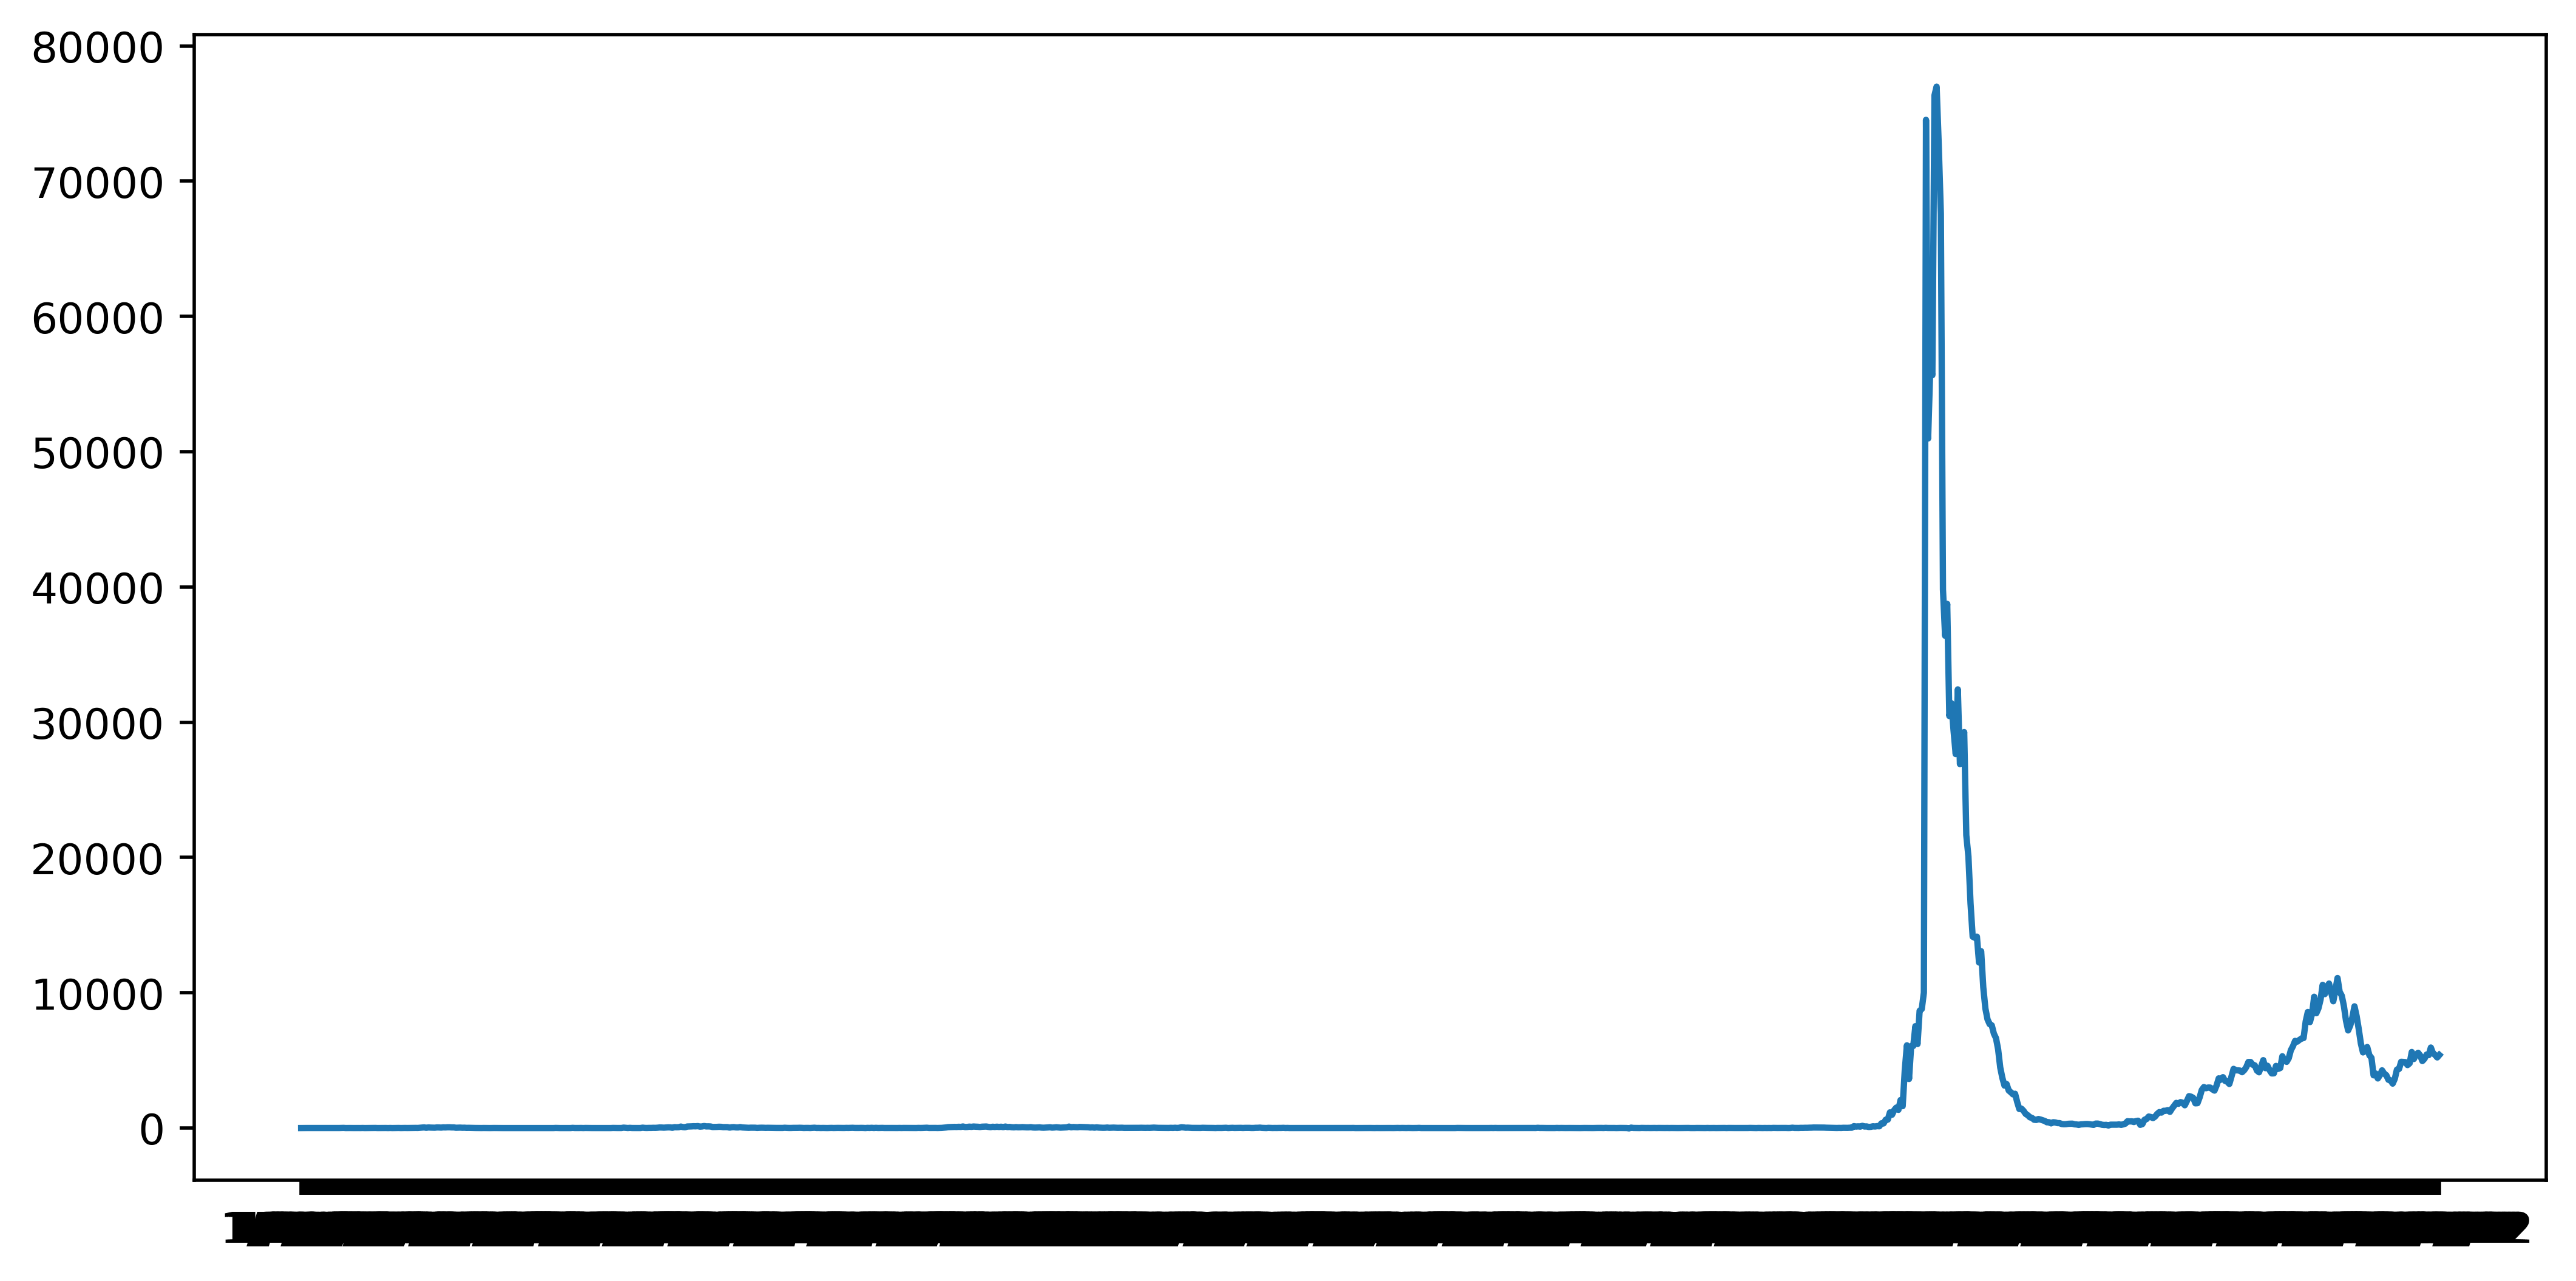

In [18]:
import matplotlib.pyplot as plt

plt.figure(1, (10,5), dpi = 500)
plt.plot(DailyConfirmed.index, DailyConfirmed["confirmed"])
plt.show()


# 发现问题
1. 能否把刻度去掉
2. 找出节点
3. 缩放

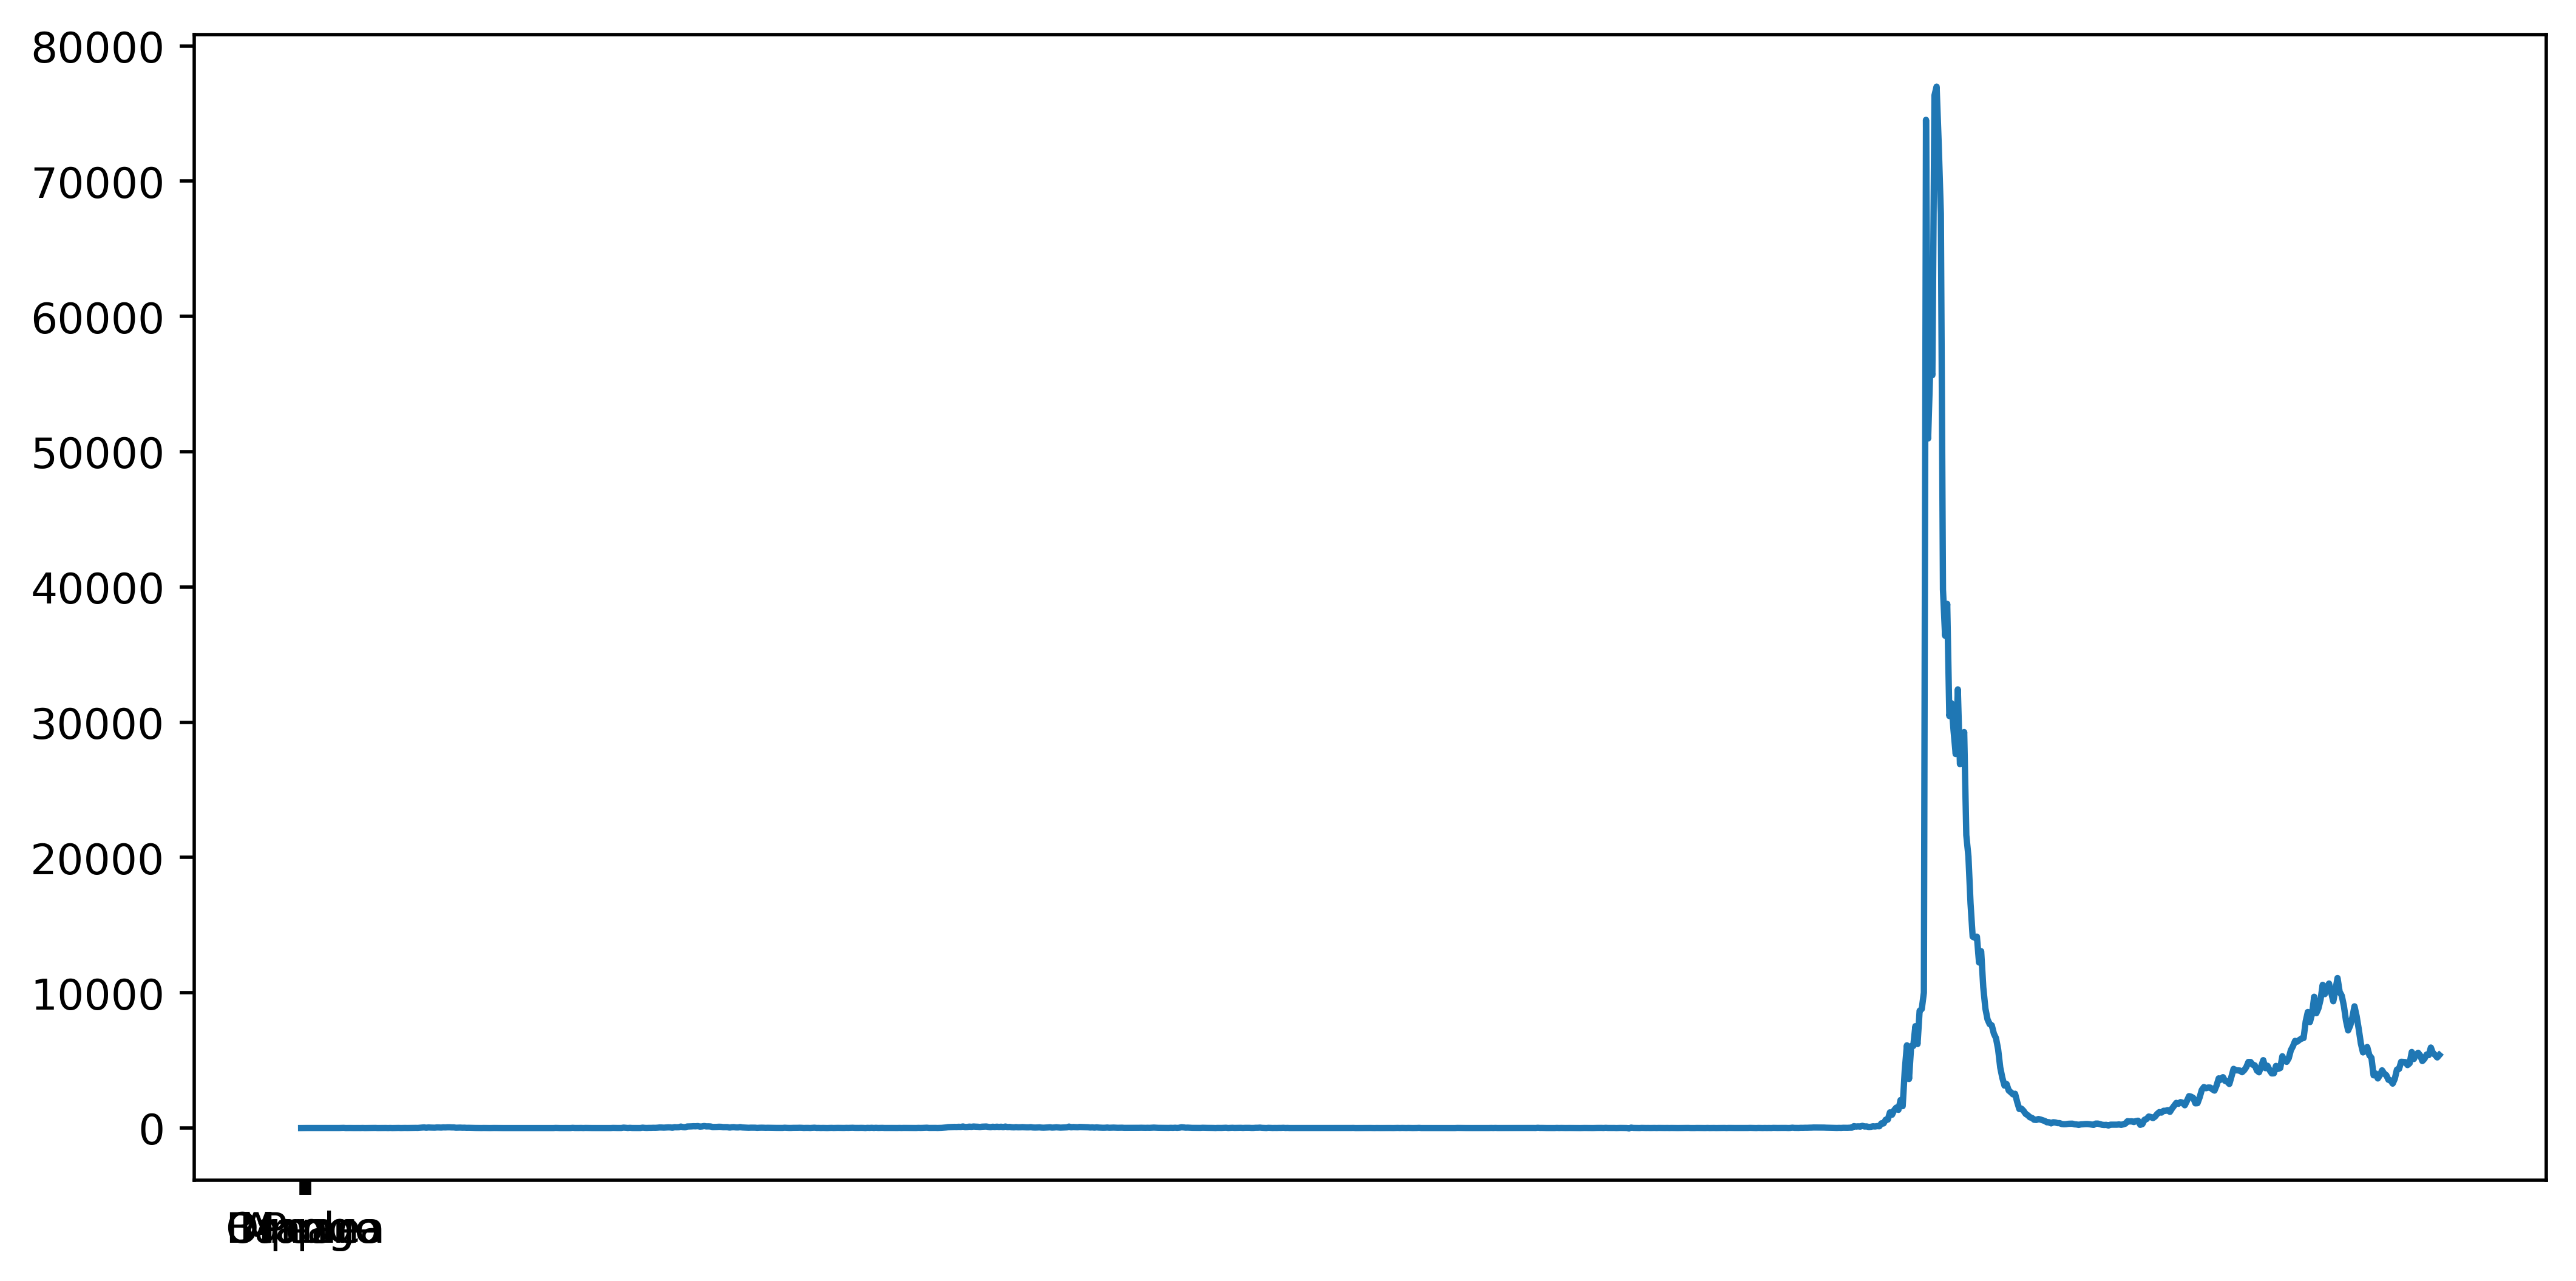

In [20]:
import numpy as np
plt.figure(1, (10,5), dpi = 500)
plt.plot(DailyConfirmed.index, DailyConfirmed["confirmed"])

name_list = ('1/22/20 ')
pos_list = np.arange(len(name_list))
plt.xticks(pos_list, name_list)

plt.show()

In [22]:
from kneed import KneeLocator

outputlist = []
def knee_point_search(x, y):
    
    # 转为list以支持负号索引
    x, y = x.tolist(), y.tolist()
    output_knees = []
    for curve in ['convex', 'concave']:
        for direction in ['increasing', 'decreasing']:
            model = KneeLocator(x=x, y=y, curve=curve, direction=direction, online=False)
            if model.knee != x[0] and model.knee != x[-1]:
                output_knees.append((model.knee, model.knee_y, curve, direction))
    
    if output_knees.__len__() != 0:
        print('发现拐点！')
        return output_knees
    else:
        print('未发现拐点！')

In [48]:
DailyConfirmed

,index,confirmed
0,1/22/20,0
1,1/23/20,2
2,1/24/20,0
3,1/25/20,3
4,1/26/20,3
...,...,...
1004,10/22/22,5953
1005,10/23/22,5535
1006,10/24/22,5406
1007,10/25/22,5221


发现拐点！
[(1007, 5221, 'convex', 'increasing')]
发现拐点！
[(885, 1235960, 'convex', 'increasing')]


发现拐点！
发现拐点！


f:\solfware\python3.7\lib\site-packages\ipykernel_launcher.py:23: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
f:\solfware\python3.7\lib\site-packages\ipykernel_launcher.py:27: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.


<Figure size 5000x2500 with 0 Axes>

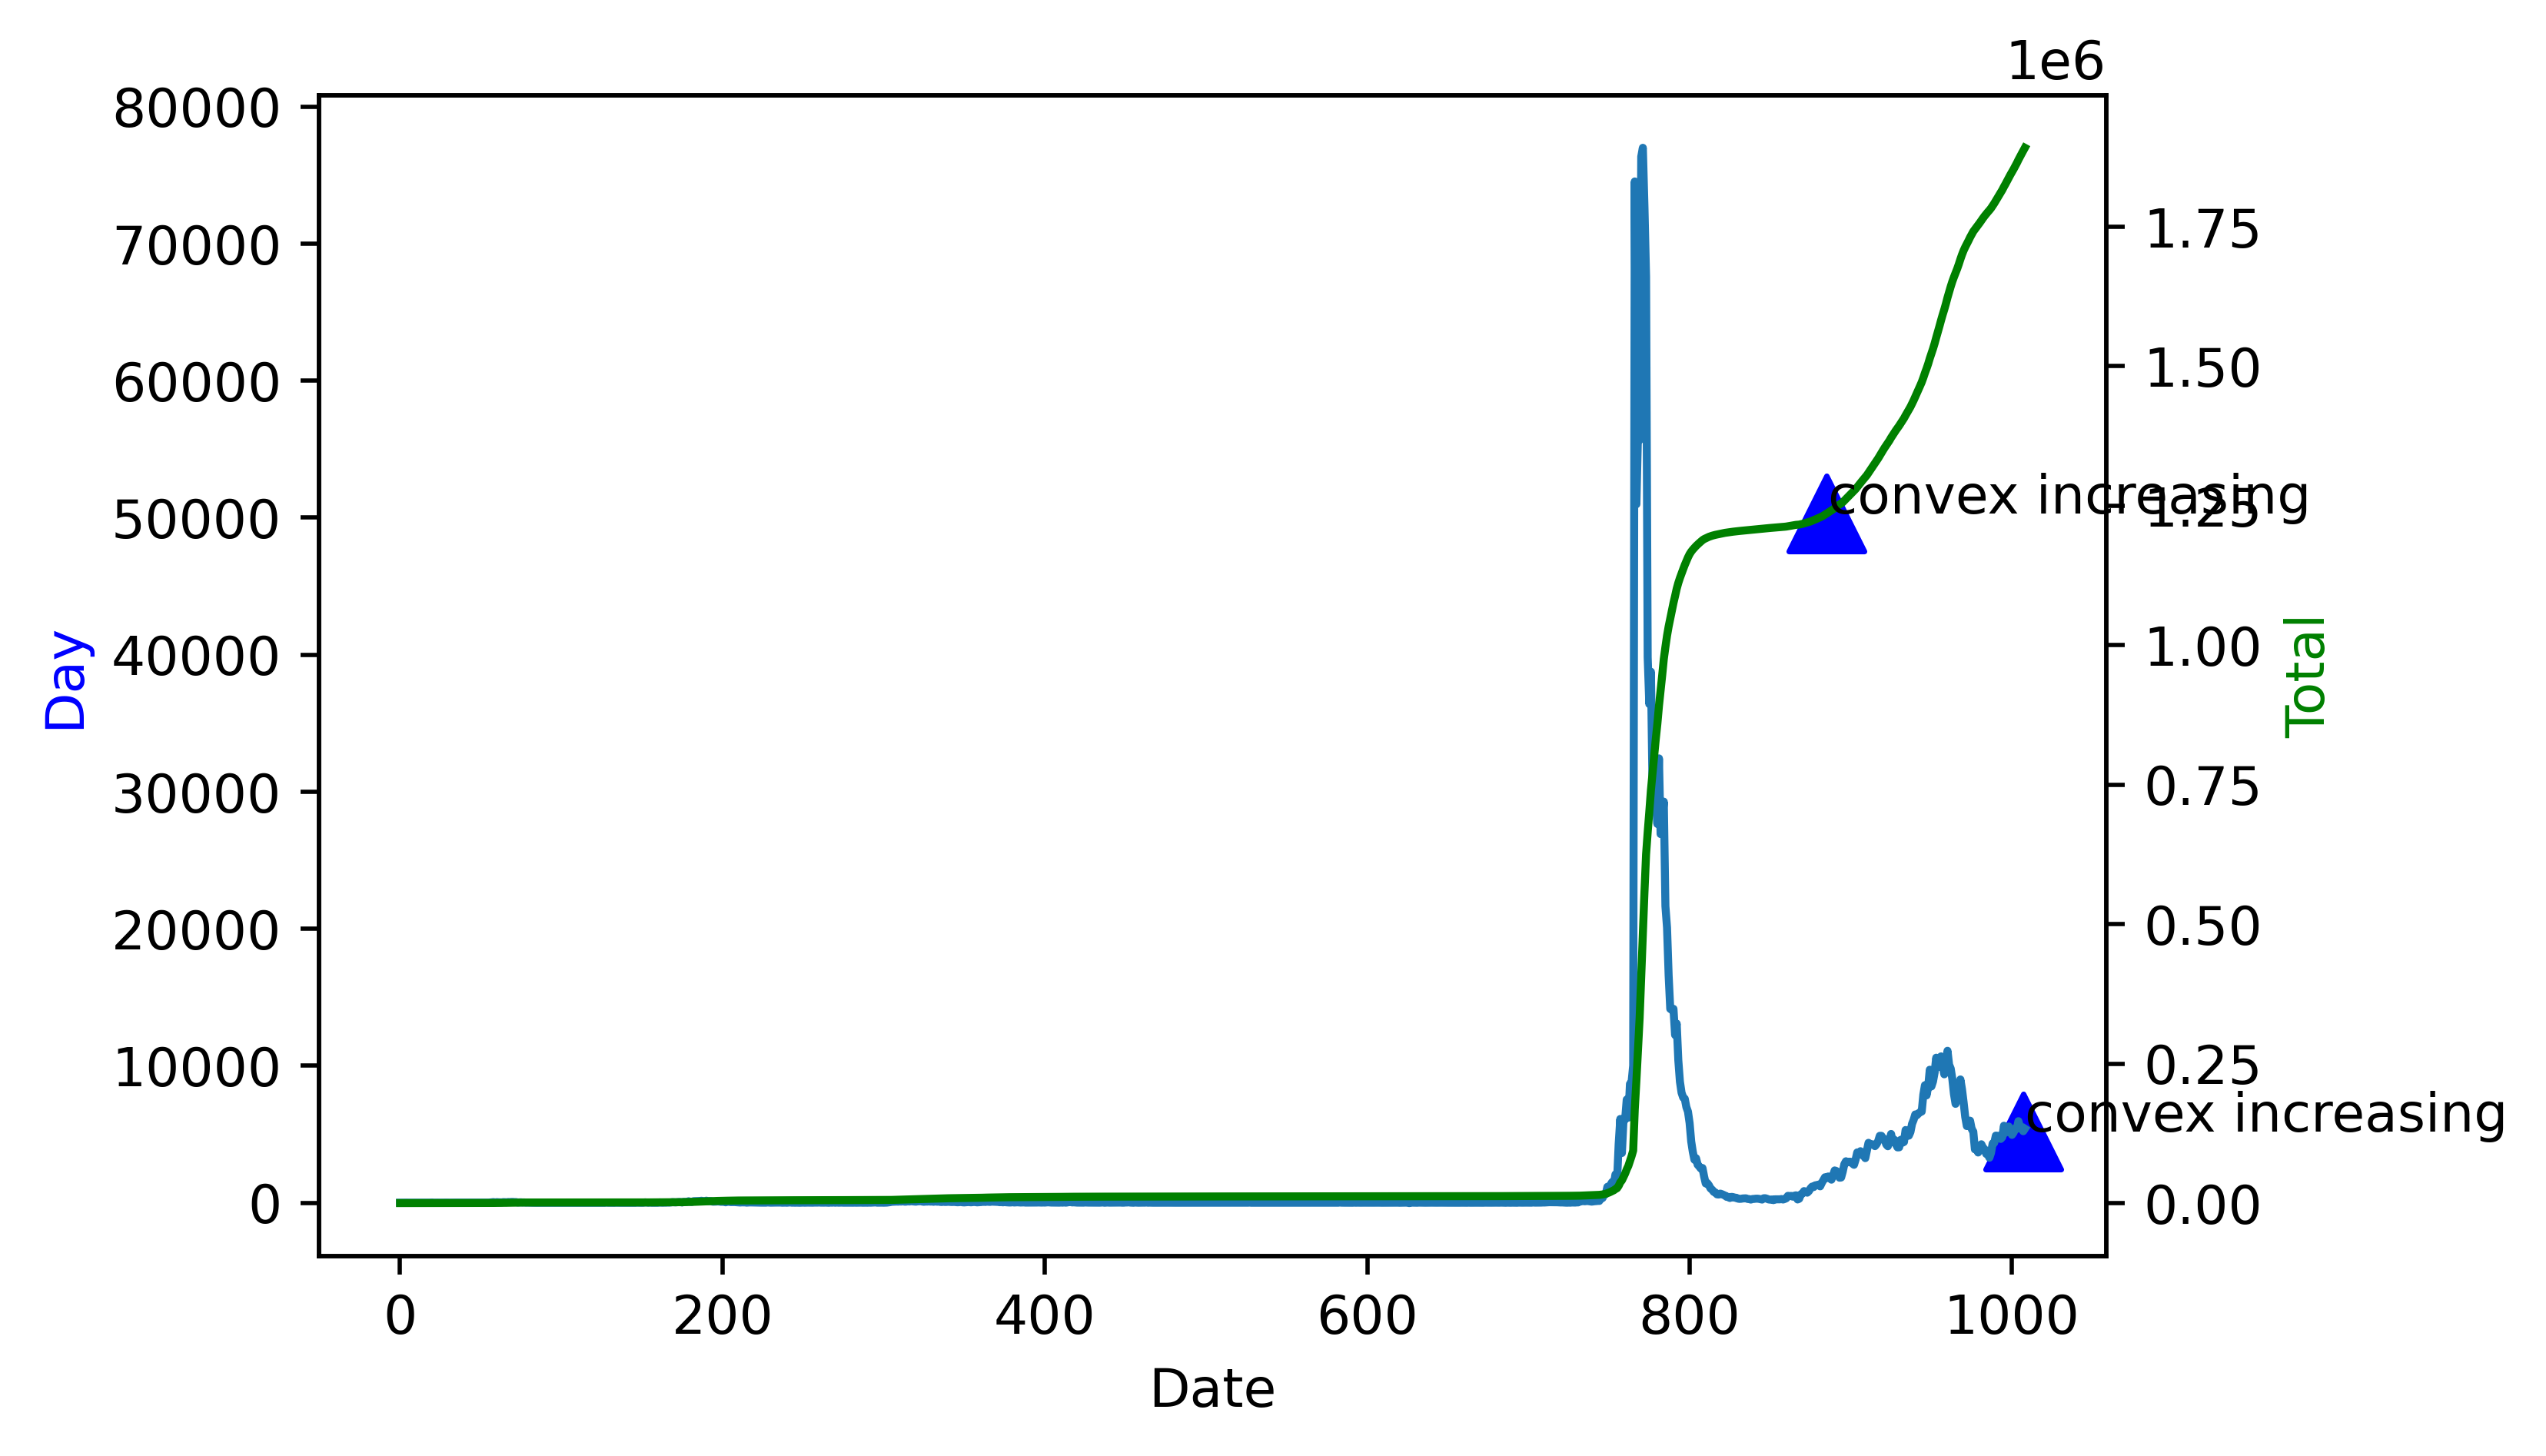

In [12]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(1, (10,5), dpi = 500)
fig,ax1 = plt.subplots(dpi = 500)

ax2 = ax1.twinx()

ax1.plot(DailyConfirmed.index, DailyConfirmed["confirmed"])
ax2.plot(DailyConfirmed["total"],'g')
#############################################
knee_info_Con = knee_point_search(DailyConfirmed.index, DailyConfirmed["confirmed"])
##print(knee_info_Con)

knee_info_Tol = knee_point_search(DailyConfirmed.index, DailyConfirmed["total"])
##print(knee_info_Tol)
#############################################


for point in knee_info_Con:
    ax1.scatter(x=point[0], y=point[1], c='b', s=200, marker='^')
    ax1.annotate(s=f'{point[2]} {point[3]}', xy=(point[0]+1, point[1]), fontsize=10)
    
for point in knee_info_Tol:
    ax2.scatter(x=point[0], y=point[1], c='b', s=200, marker='^')
    ax2.annotate(s=f'{point[2]} {point[3]}', xy=(point[0]+1, point[1]), fontsize=10)   

ax1.set_xlabel('Date')
ax1.set_ylabel("Day",color='b')
ax2.set_ylabel('Total',color='g')

plt.show()


# 发现快到800之前才有明显起伏，zoom一下剩下的date


In [34]:
DailyConfirmed_Zoom = DailyConfirmed.copy()

In [35]:
DailyConfirmed_Zoom = DailyConfirmed_Zoom.loc[725:,]

In [36]:
DailyConfirmed_Zoom

,index,confirmed,total
725,1/16/22,11,13041
726,1/17/22,7,13048
727,1/18/22,18,13066
728,1/19/22,16,13082
729,1/20/22,14,13096
...,...,...,...
1004,10/22/22,5953,1870066
1005,10/23/22,5535,1875601
1006,10/24/22,5406,1881007
1007,10/25/22,5221,1886228


未发现拐点！
未发现拐点！


<Figure size 5000x2500 with 0 Axes>

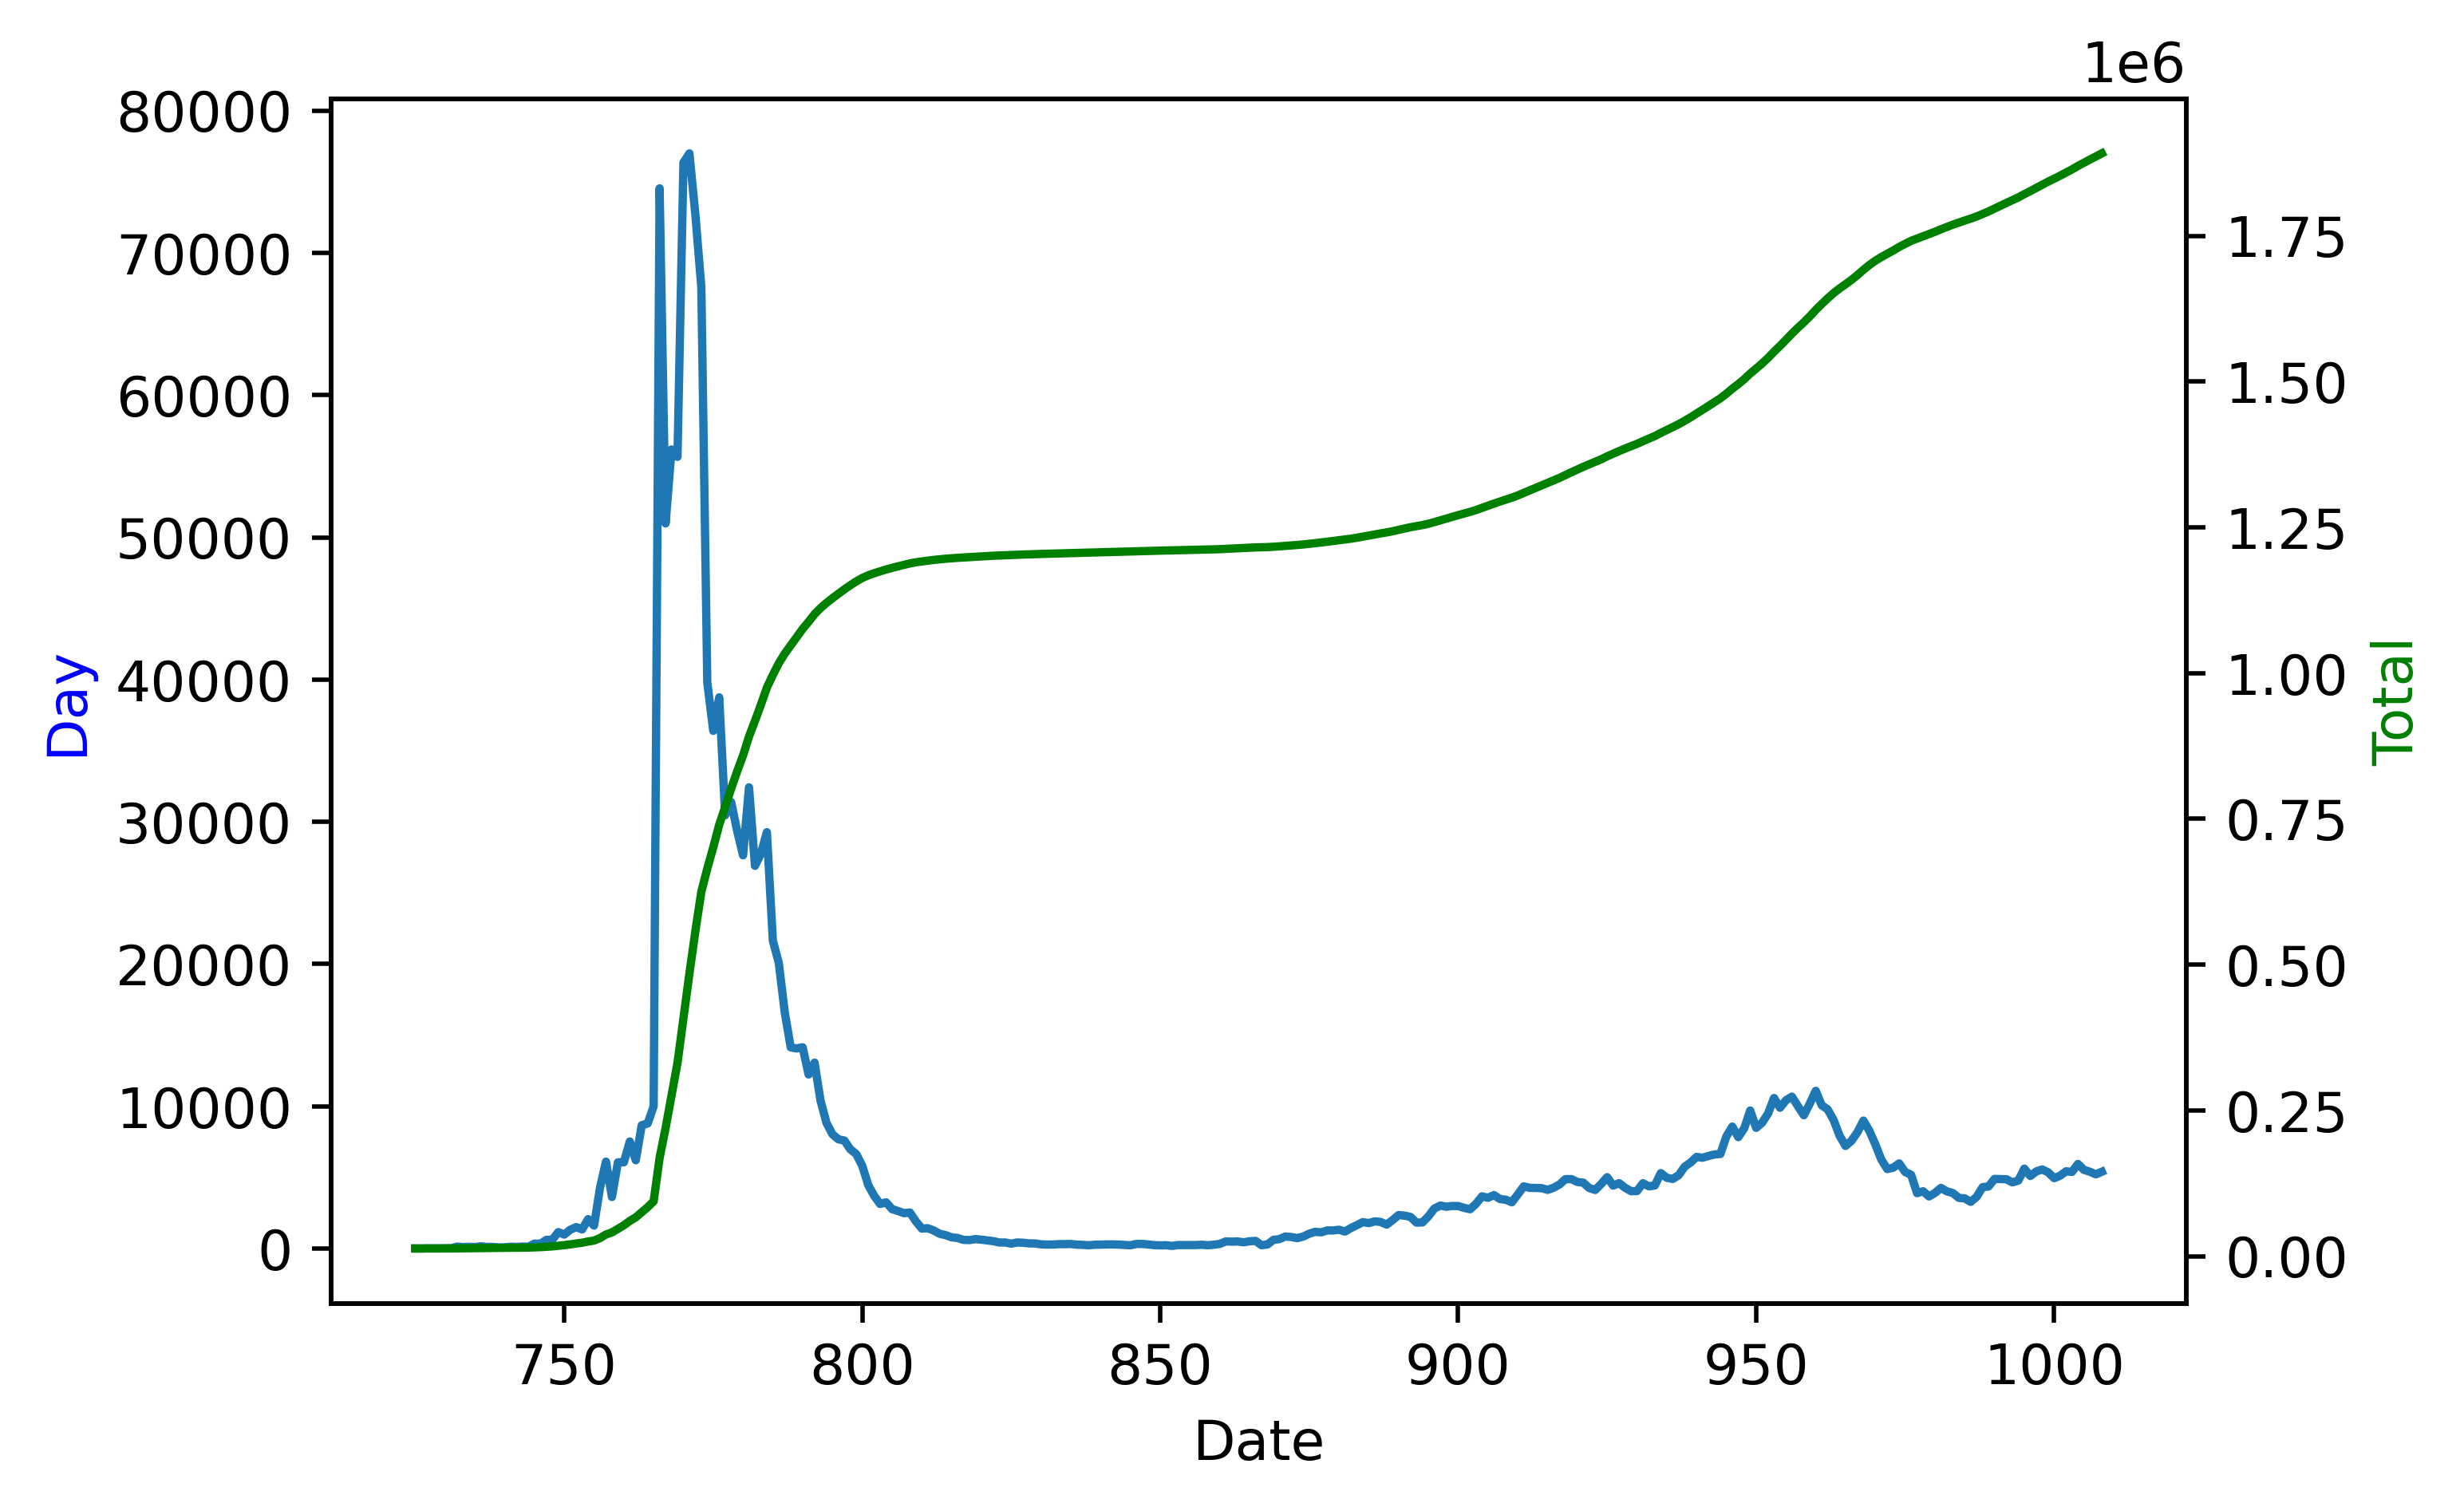

In [37]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure(1, (10,5), dpi = 500)
fig,ax1 = plt.subplots(dpi = 500)

ax2 = ax1.twinx()

ax1.plot(DailyConfirmed_Zoom.index, DailyConfirmed_Zoom["confirmed"])
ax2.plot(DailyConfirmed_Zoom["total"],'g')
#############################################
knee_info_Con = knee_point_search(DailyConfirmed_Zoom.index, DailyConfirmed_Zoom["confirmed"])
##print(knee_info_Con)

knee_info_Tol = knee_point_search(DailyConfirmed_Zoom.index, DailyConfirmed_Zoom["total"])
##print(knee_info_Tol)
#############################################

if ( knee_info_Con!= None ):
    for point in knee_info_Con:
        ax1.scatter(x=point[0], y=point[1], c='b', s=200, marker='^')
        ax1.annotate(s=f'{point[2]} {point[3]}', xy=(point[0]+1, point[1]), fontsize=10)
        
    for point in knee_info_Tol:
        ax2.scatter(x=point[0], y=point[1], c='b', s=200, marker='^')
        ax2.annotate(s=f'{point[2]} {point[3]}', xy=(point[0]+1, point[1]), fontsize=10)   

ax1.set_xlabel('Date')
ax1.set_ylabel("Day",color='b')
ax2.set_ylabel('Total',color='g')

plt.show()